<a href="https://colab.research.google.com/github/Utkarshp1/Bayesian_Optimisation/blob/master/Gaussian_Processes_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression using GPytorch

In [2]:
!pip install gpytorch

     |████████████████████████████████| 501kB 4.6MB/s 


In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Train an RBF kernel Gaussian process on a simple function. We'll be modelling the function <br />
$$ y = sin(2\pi x) + \epsilon $$
$$ \epsilon \stackrel{}{\sim} \mathcal{N}(0, 0.04) $$

In [10]:
X_train = torch.linspace(0, 1, 100)
y_train = torch.sin(X_train * (2*math.pi)) + torch.randn(X_train.size())*math.sqrt(0.04)

X_test = torch.linspace(0, 1, 51)
y_test = torch.sin(X_test * (2*math.pi)) + torch.randn(X_test.size())*math.sqrt(0.04)

## Model Definition

In [13]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

## Training Loop

In [14]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # Includes GaussianLikelihood parameters

# "loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train)
    # Calculate loss and backpropagate gradients
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  lengthscale: %.3f   noise: %.3f' % (
        i+1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.944  lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.913  lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.879  lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.842  lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.799  lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.751  lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.699  lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.646  lengthscale: 0.405   noise: 0.402
Iter 9/50 - Loss: 0.595  lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.548  lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.505  lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.465  lengthscale: 0.291   noise: 0.284
Iter 13/50 - Loss: 0.428  lengthscale: 0.270   noise: 0.259
Iter 14/50 - Loss: 0.393  lengthscale: 0.253   noise: 0.236
Iter 15/50 - Loss: 0.359  lengthscale: 0.239   noise: 0.215
Iter 16/50 - Loss: 0.326  lengthscale: 0.228   noise: 0.196
Iter 17/50 - Loss: 0.293  lengthscale: 0.219   no

## Make predictions with the model

In [ ]:
f_preds = model(X_test)
y_preds = likelihood(model(X_test))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_test = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(X_test))

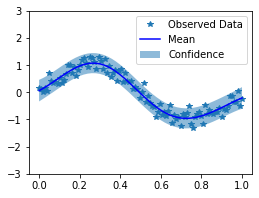

In [17]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), y_train.numpy(), '*')
    # Plot predictive means as blue line
    ax.plot(X_test.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])